# Wide Neural Network

An implementation of Zheng's Wide Neural Network (WNN).

# Imports

In [0]:
import numpy as np
import pandas as pd 

# Seed random number generator for reproducible results
np.random.seed(42)

# Plotting imports - Seaborn
from seaborn import distplot, heatmap

# Plotting imports - Matplotlib
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')

# Scikit-Learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score, roc_curve

# Have to use Tensorflow's distribution of Keras for compatibility with metrics
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Functions


### Function 1 - Feature Scaler 

Defining a single function to help scale data according to specified scaling strategy.

Under the hood it uses a `Scikit-Learn` feature scaler object to apply the right kind of feature scaling to the data. 

All you need to do is specify one of following values for the `scaling_strategy` argument
- `Standard`: all features will have mean of 0, standard deviation of 1.
- `MinMax`: all feature values `x` will be scaled according to `(x - x_min)/(x_max - x_min)`, where `x_min` and `x_max` are the minimum and maximum values for that feature.
- `MaxAbs`: all feature valeus `x` will be scaled according t `(x / abs(x_max))` where `x_max` is the maximum value of the feature, and `abs` is a function that finds its absolute value. 

Zheng has used `MinMax`, but my results show `Standard` to be more effective. 

You can also specify whether or not you want to compare the distribution of kWhs before and after scaling using the `plot_distributions` argument. **Plotting distributions will cause the function to take a little more time than usual to execute**.

In [0]:
def scale_features(X=kWhs, scaling_strategy='Standard', plot_distributions=False):
  """Allows user to scale features for individual samples using specified scaling strategy.
  `Standard` - all features scaled to have mean 0, standard deviation of 1
  `MinMax` - all features scaled according to x - x_min / (x_max - x_min)
  `MaxAbs` - all features scaled according to x / abs(x_max)
  
  Returns matrix of scaled features as a numpy array.

  Also allows before/after plots of feature values to compare effect of scaling
  """
  # StandardScaler - all features will have mean of 0, and std deviation of 1
  if (scaling_strategy=='Standard'):
    # Instantiate a StandardScaler object
    scaler = StandardScaler()
  elif (scaling_strategy=='MinMax'):
    scaler = MinMaxScaler()
  elif (scaling_strategy=='MaxAbs'):
    scaler = MaxAbsScaler()

  # Make a copy of the features, transpose so that consumers become columns
  X_copy = X.copy().transpose()

  # Once consumers are in columns, scale each consumer using scaler object and retranspose results 
  # Retransposing ensures that in scaled data, the consumers are still rows
  X_scaled = scaler.fit_transform(X_copy).transpose() # THIS IS A NUMPY ARRAY, NOT A DATAFRAME

  # If the user has asked to compare distributions
  if plot_distributions:
    # First figure - before scaling
    plt.figure(figsize=(12, 6))
    distplot(X.values.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Unscaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - Before Scaling', fontsize=18)

    # Second figure - after scaling
    plt.figure(figsize=(12, 6))
    distplot(X_scaled.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Scaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - After {} Scaling'.format(scaling_strategy), fontsize=18)

  # Return the scaled features
  return X_scaled

### Function 2 - Plotting Training History
Generates figures to compare training and validation loss as well as area under the receiver operating characteristics curve (AUC). 

Unlike loss and validation loss, which will always be identified by `loss` and `val_loss` in the `.history` object's keys, the AUC keys are not fixed, will be numbered `auc_1`, `val_auc_2`, etc. depending on the number of `tf.keras.metrics.AUC` objects instantiated.

A large part of this function is a quick and dirty approach to extracting the `auc` and `val_auc` keys.

In [0]:
def plot_history(history, model_name=None, figsize=(12, 6), 
                 loss_name='Binary Crossentropy'):
  # Extract loss from the history object
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  # Extract AUCs
  auc = None
  val_auc = None

  # Extract `auc` and `val_auc` regardless of last number in key
  for key in list(history.history.keys()):
    if 'auc' in key and 'val' not in key:
      auc = history.history[key]
    elif 'auc'in key and 'val' in key:
      val_auc = history.history[key]

  # Plotting Loss
  plt.figure(figsize=figsize)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs', fontsize=14)
  plt.ylabel(loss_name, fontsize=14)
  plt.title('Loss ' + ('' if model_name is None else ' - {}'.format(model_name)), 
            fontsize=18)
  plt.legend(loc='lower right')

  # Plotting AUC - only if in dictionary
  if auc is not None and val_auc is not None:
    plt.figure(figsize=figsize)
    plt.plot(epochs, auc, label='Training AUC')
    plt.plot(epochs, val_auc, label='Validation AUC')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('AUC', fontsize=14)
    plt.title('AUC ' + ('' if model_name is None else' - {}'.format(model_name)), 
              fontsize=18)

### Function 3 - Classification Results

Generates 
- a classification report (with precision, accuracy, recall, and F1 score)
- a confusion matrix (showing the proportion of true and false positives and negatives).
- a ROC curve with AUC

Make sure the following imports have been made before running the function
- `from sklearn.metrics import classification_report, roc_auc_score, roc_curve`

- `from seaborn import heatmap`

In [0]:
def get_classification_result(model, X_test, y_true, model_name=None, 
                              normalize_conf_mat='all'):
  """Displays classification report, confusion matrix, and ROC curve for a trained
  model using classification results on data provided"""
  # PREDICTIONS
  # First, get the predictions for the test data
  y_pred = model.predict_classes(X_test)

  # CLASSIFICATION REPORT
  print("classification report".upper(), end='\n')
  print(classification_report(y_true, y_pred, labels=[0, 1], 
                              target_names=['Regular Consumer', 'Thief']))
  
  # CONFUSION MATRIX
  if (normalize_conf_mat=='rows'):
    normalize='true'
  elif (normalize_conf_mat=='cols'):
    normalize='pred'
  else:
    normalize='all'

  # Using Seaborn to plot confusion matrix as a heatmap 
  conf_mat = confusion_matrix(y_true, y_pred, normalize=normalize)

  # Create a heatmap in lieu of the plot_confusion_matrix call in sklearn
  plt.figure(figsize=(8, 8))
  heatmap(conf_mat, annot=True, fmt='.5g', cmap='Blues', 
        xticklabels=['Predicted Reg', 'Predicted Thief'], 
        yticklabels=['True Reg', 'True Thief'])
  plt.title('Confusion Matrix ' + ('' if model_name is None else ' - ' + model_name))

  # ROC Curve
  plt.figure(figsize=(8, 8))
  fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
  roc_auc = roc_auc_score(y_true, y_pred)
  plt.plot(fpr, tpr, lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
  plt.xlabel('False Positive Rate', fontsize=14)
  plt.ylabel('True Positive Rate', fontsize=14)
  plt.title('ROC Curve' + ('' if model_name is None else (' - ' + model_name)))
  plt.legend(loc='lower right')
  

# Loading Data

**What is being loaded?**: `outliersRemoved.csv` 
This data is sorted, has no missing values, and has no outliers. However, it is **not scaled**.

You will scale the data as you wish by running the cells in the **Scaling** section.

In [0]:
filepath = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv'

In [0]:
raw_data = pd.read_csv(filepath)

In [357]:
# Did it work?
raw_data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


# Extracting Features and Labels

In [0]:
# Column 2 onwards are kWhs, column 1 is the FLAG
kWhs = raw_data.iloc[:, 2:]
labels = raw_data.iloc[:, 1]

In [0]:
# Extracting number of rows and columns in the feature matrix
NUM_CONSUMERS, NUM_DAYS = kWhs.shape

In [360]:
print(NUM_CONSUMERS, NUM_DAYS)

42372 1034


# Scaling

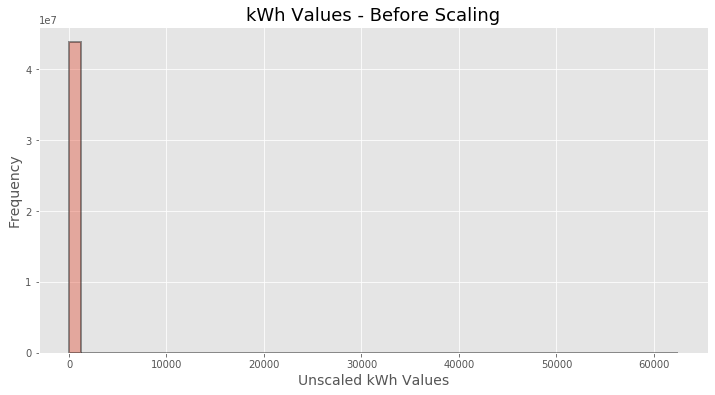

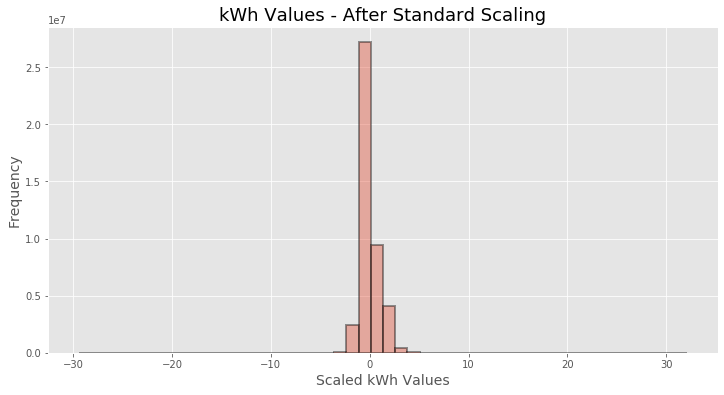

In [171]:
X_scaled_std = scale_features(X=kWhs, plot_distributions=True)

# Train-Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_std, 
                                                    labels, 
                                                    stratify=labels, 
                                                    shuffle=True, 
                                                    test_size=0.2, 
                                                    random_state=0)

# Wide NN - Zheng's Model

In [0]:
# Insantiate a Model
model = Sequential()

## Adding Layers

Zheng's wide model has a single layer which takes a 1034-dimensional input. 

**Number of Neurons**: The paper is unclear about the optimal number of neurons. In the description, it states that V.C.1) (Parameter Study, Effect of Alpha), it states the optimal number of neurons is 50. However, the graphs of the parameter study presented in figure 6(a)-(b) show that highest AUC is obtained when number of neurons is closer to 90.

**Activation Function**: `ReLu`, as defined in paper. 

**No regularizaton** specified. 

### `Wide` Input Layer

In [0]:
model.add(Dense(units=90, 
                activation='relu', 
                input_shape=(1034,)))

### `Sigmoid` Layer

In [0]:
model.add(Dense(units=1, activation='sigmoid'))

## Compiling Model

In [0]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy', 
              metrics=[AUC()])

## Model Summary

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 90)                93150     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 91        
Total params: 93,241
Trainable params: 93,241
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [0]:
wide_history = model.fit(X_train, y_train,
                         validation_split=0.2, 
                         epochs=20, 
                         verbose=1)

Train on 27117 samples, validate on 6780 samples
Epoch 1/20
27117/27117 [==============================] - 6s 215us/sample - loss: 0.3255 - auc_2: 0.5578 - val_loss: 0.3087 - val_auc_2: 0.6124
Epoch 2/20
27117/27117 [==============================] - 3s 129us/sample - loss: 0.2881 - auc_2: 0.6538 - val_loss: 0.2936 - val_auc_2: 0.6504
Epoch 3/20
27117/27117 [==============================] - 3s 129us/sample - loss: 0.2735 - auc_2: 0.6977 - val_loss: 0.2905 - val_auc_2: 0.6595
Epoch 4/20
27117/27117 [==============================] - 3s 125us/sample - loss: 0.2617 - auc_2: 0.7314 - val_loss: 0.2916 - val_auc_2: 0.6520
Epoch 5/20
27117/27117 [==============================] - 4s 131us/sample - loss: 0.2528 - auc_2: 0.7574 - val_loss: 0.2889 - val_auc_2: 0.6823
Epoch 6/20
27117/27117 [==============================] - 3s 128us/sample - loss: 0.2445 - auc_2: 0.7803 - val_loss: 0.2753 - val_auc_2: 0.7126
Epoch 7/20
27117/27117 [==============================] - 3s 125us/sample - loss: 0.235

## Model History

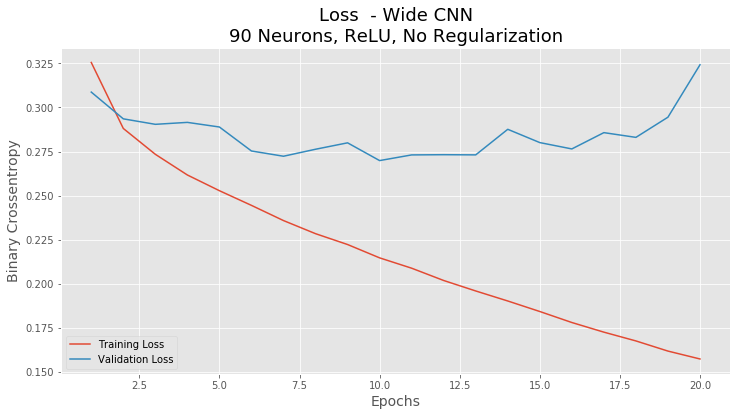

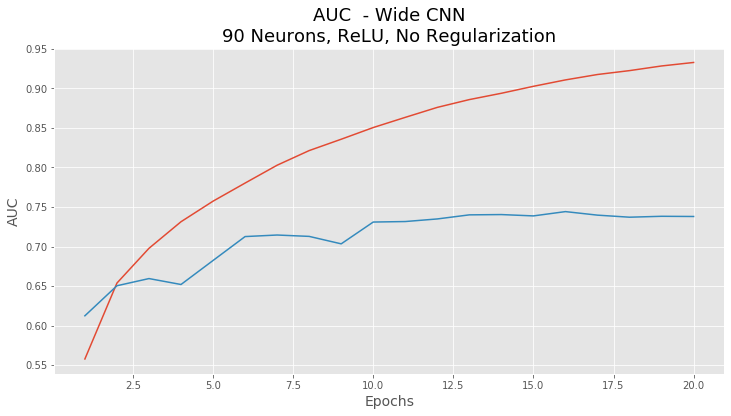

In [0]:
plot_history(history=wide_history, 
             model_name='Wide CNN\n90 Neurons, ReLU, No Regularization', 
             loss_name='Binary Crossentropy')

## Evaluation Results

**I HAVE EVALUATED THIS MODEL ON A SUBSET OF THE TRAINING DATA**.

I expect there will be a lot of hyperparameter tuning on this model going forward, so it does not make sense to evaluate it on the test data. 

Instead, I am going to extract 20% of randomly selected samples from the training set and evaluate the results on it. 

In [0]:
_, X_val, _, y_val = train_test_split(X_train, y_train,   # Splitting training data
                                      stratify=y_train,
                                      random_state=42,    # Different from previous split
                                      shuffle=True, 
                                      test_size=0.2)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.96      0.96      0.96      6202
           Thief       0.56      0.60      0.58       578

        accuracy                           0.93      6780
       macro avg       0.76      0.78      0.77      6780
    weighted avg       0.93      0.93      0.93      6780



CONFUSION MATRIX


ROC CURVE


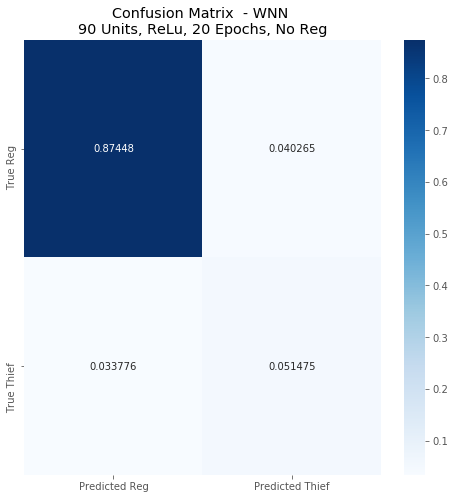

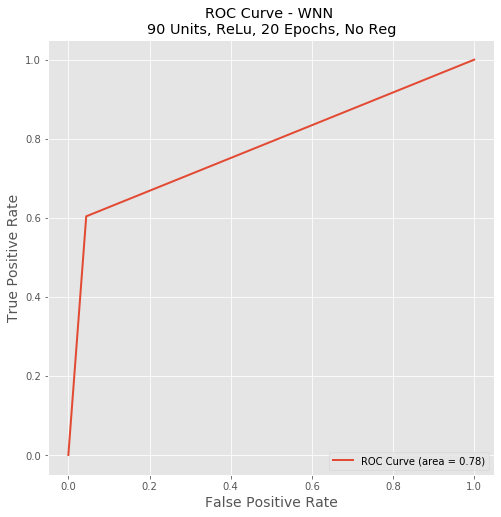

In [0]:
get_classification_result(model=model, X_test=X_val, y_true=y_val,
                          model_name='WNN \n90 Units, ReLu, 20 Epochs, No Reg')

# Wide NN - With Dropout

Same network as before. Training with 80% training ratio using network of 90 `ReLu` units in first layer and `sigmoid` unit in the output layer. 

Also adding `Dropout` layer between I/O with dropout rate of 0.2 for initial investigation.

## Base Model

In [0]:
# Instantiate a model
model_dropout = Sequential()

### Input Layer

In [0]:
model_dropout.add(Dense(units=90, activation='relu', input_shape=(1034, )))

### Dropout Layer

In [0]:
dropout_rate = 0.25
model_dropout.add(Dropout(rate=dropout_rate, 
                          seed=0)) # For reproducibility across trainings

### Sigmoid Layer

In [0]:
model_dropout.add(Dense(units=1, activation='sigmoid'))

### Model Summary

In [267]:
model_dropout.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 90)                93150     
_________________________________________________________________
dropout_13 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 91        
Total params: 93,241
Trainable params: 93,241
Non-trainable params: 0
_________________________________________________________________


### Compiling

In [0]:
model_dropout.compile(optimizer='rmsprop', 
                      loss='binary_crossentropy', 
                      metrics=[AUC()])

### Training

In [269]:
dropout_model_history = model_dropout.fit(X_train, y_train, 
                                  validation_split=0.2, 
                                  batch_size=128, 
                                  epochs=20, 
                                  verbose=1)

Train on 27117 samples, validate on 6780 samples
Epoch 1/20
27117/27117 [==============================] - 2s 61us/sample - loss: 0.3409 - auc_13: 0.5827 - val_loss: 0.2988 - val_auc_13: 0.6552
Epoch 2/20
27117/27117 [==============================] - 1s 38us/sample - loss: 0.2855 - auc_13: 0.6783 - val_loss: 0.2955 - val_auc_13: 0.6662
Epoch 3/20
27117/27117 [==============================] - 1s 39us/sample - loss: 0.2636 - auc_13: 0.7388 - val_loss: 0.2810 - val_auc_13: 0.7051
Epoch 4/20
27117/27117 [==============================] - 1s 38us/sample - loss: 0.2507 - auc_13: 0.7678 - val_loss: 0.2819 - val_auc_13: 0.7159
Epoch 5/20
27117/27117 [==============================] - 1s 38us/sample - loss: 0.2402 - auc_13: 0.7978 - val_loss: 0.2886 - val_auc_13: 0.7109
Epoch 6/20
27117/27117 [==============================] - 1s 39us/sample - loss: 0.2320 - auc_13: 0.8179 - val_loss: 0.2841 - val_auc_13: 0.7290
Epoch 7/20
27117/27117 [==============================] - 1s 38us/sample - loss: 

### Training History

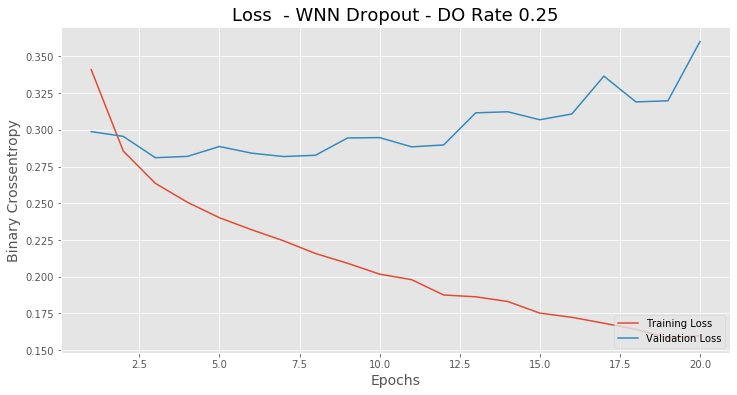

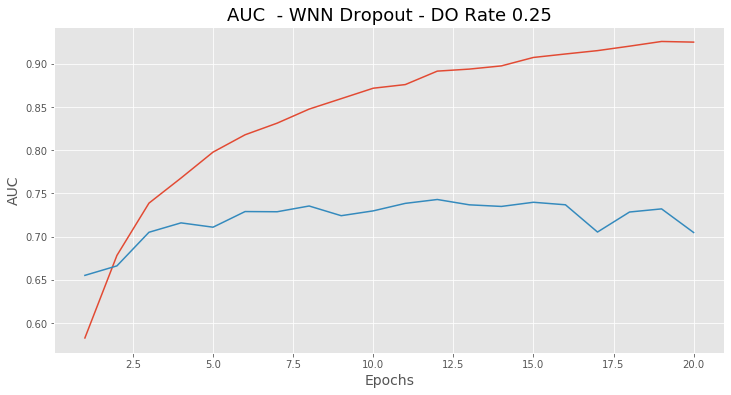

In [271]:
plot_history(history=dropout_model_history,
             model_name='WNN Dropout - DO Rate ' + str(dropout_rate), 
             loss_name='Binary Crossentropy')

## Dropout Model Build Function

First step towards the inevitable grid search lol. Returns a WNN with a specified dropout rate.

In [0]:
def build_dropout_model(dropout_rate=0.25):
  model = Sequential()
  model.add(Dense(activation='relu', units=90, input_shape=(1034, )))
  model.add(Dropout(rate=dropout_rate))
  model.add(Dense(units=1, activation='sigmoid'))

  model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                metrics=[AUC()])

  return model

## Dropout Model - 0.1

### Train

In [336]:
dropout_0_1 = build_dropout_model(0.1)
dropout_0_1_history = dropout_0_1.fit(X_train, y_train,
                                      batch_size=128, 
                                      epochs=20, 
                                      validation_split=0.2, 
                                      verbose=1)

Train on 27117 samples, validate on 6780 samples
Epoch 1/20
27117/27117 [==============================] - 2s 75us/sample - loss: 0.3395 - auc_24: 0.5896 - val_loss: 0.3058 - val_auc_24: 0.6591
Epoch 2/20
27117/27117 [==============================] - 1s 38us/sample - loss: 0.2764 - auc_24: 0.7030 - val_loss: 0.3108 - val_auc_24: 0.6949
Epoch 3/20
27117/27117 [==============================] - 1s 37us/sample - loss: 0.2537 - auc_24: 0.7636 - val_loss: 0.2918 - val_auc_24: 0.6999
Epoch 4/20
27117/27117 [==============================] - 1s 39us/sample - loss: 0.2357 - auc_24: 0.8060 - val_loss: 0.2859 - val_auc_24: 0.7307
Epoch 5/20
27117/27117 [==============================] - 1s 38us/sample - loss: 0.2236 - auc_24: 0.8347 - val_loss: 0.2958 - val_auc_24: 0.7236
Epoch 6/20
27117/27117 [==============================] - 1s 38us/sample - loss: 0.2128 - auc_24: 0.8519 - val_loss: 0.2806 - val_auc_24: 0.7383
Epoch 7/20
27117/27117 [==============================] - 1s 38us/sample - loss: 

### Training History

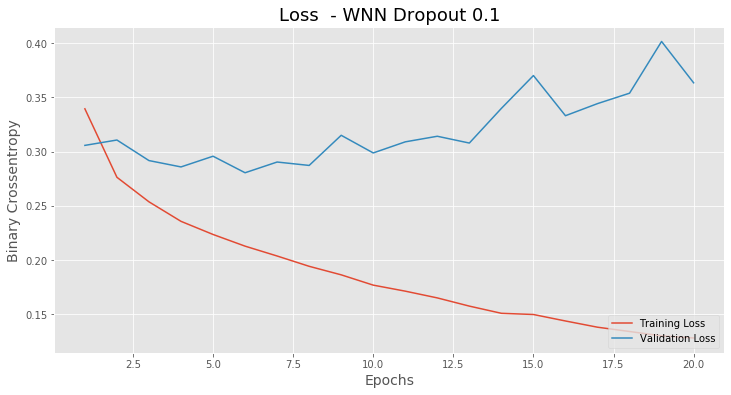

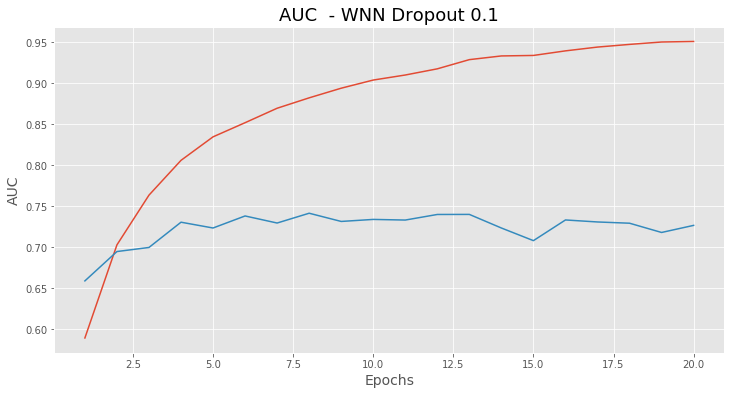

In [337]:
plot_history(history=dropout_0_1_history, 
             model_name='WNN Dropout 0.1', 
             loss_name='Binary Crossentropy')

## Dropout Model - 0.25

This is also identical to the base model I trained initially.

In [0]:
dropout_model_0_25 = build_dropout_model() # Default rate is 0.25

### Train

In [338]:
dropout_model_0_25_history = dropout_model_0_25.fit(X_train, y_train,
                                                    epochs=20, batch_size=128, 
                                                    validation_split=0.2,
                                                    verbose=1)

Train on 27117 samples, validate on 6780 samples
Epoch 1/20
27117/27117 [==============================] - 2s 62us/sample - loss: 0.3383 - auc_23: 0.5809 - val_loss: 0.2987 - val_auc_23: 0.6598
Epoch 2/20
27117/27117 [==============================] - 1s 38us/sample - loss: 0.2828 - auc_23: 0.6812 - val_loss: 0.2905 - val_auc_23: 0.6737
Epoch 3/20
27117/27117 [==============================] - 1s 38us/sample - loss: 0.2648 - auc_23: 0.7337 - val_loss: 0.2865 - val_auc_23: 0.7062
Epoch 4/20
27117/27117 [==============================] - 1s 37us/sample - loss: 0.2513 - auc_23: 0.7712 - val_loss: 0.2784 - val_auc_23: 0.7249
Epoch 5/20
27117/27117 [==============================] - 1s 38us/sample - loss: 0.2413 - auc_23: 0.7950 - val_loss: 0.2822 - val_auc_23: 0.7212
Epoch 6/20
27117/27117 [==============================] - 1s 38us/sample - loss: 0.2324 - auc_23: 0.8162 - val_loss: 0.2894 - val_auc_23: 0.7104
Epoch 7/20
27117/27117 [==============================] - 1s 37us/sample - loss: 

### Training History

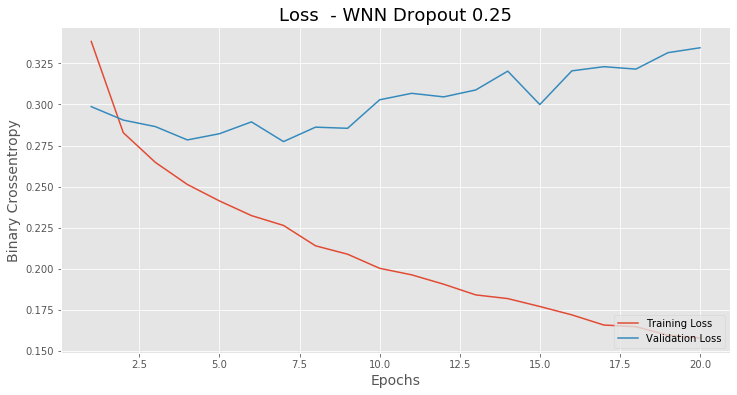

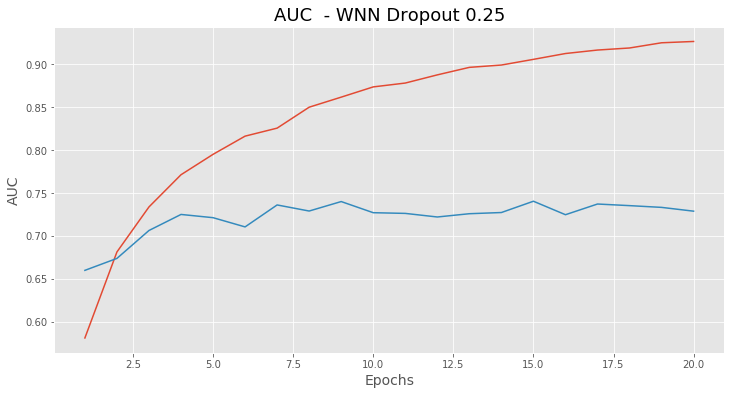

In [340]:
plot_history(history=dropout_model_0_25_history, 
             model_name='WNN Dropout 0.25', 
             loss_name='Binary Crossentropy')

## Dropout Model - 0.5

This is the maximum recommended dropout rate according to the Tensorflow API.

### Train

In [341]:
dropout_0_5_model = build_dropout_model(0.5)
dropout_0_5_history = dropout_0_5_model.fit(X_train, y_train, 
                                            validation_split=0.2, 
                                            batch_size=128, 
                                            epochs=20)

Train on 27117 samples, validate on 6780 samples
Epoch 1/20
27117/27117 [==============================] - 2s 64us/sample - loss: 0.3556 - auc_25: 0.5743 - val_loss: 0.3000 - val_auc_25: 0.6327
Epoch 2/20
27117/27117 [==============================] - 1s 44us/sample - loss: 0.3016 - auc_25: 0.6418 - val_loss: 0.2973 - val_auc_25: 0.6761
Epoch 3/20
27117/27117 [==============================] - 1s 37us/sample - loss: 0.2837 - auc_25: 0.6850 - val_loss: 0.2892 - val_auc_25: 0.6691
Epoch 4/20
27117/27117 [==============================] - 1s 39us/sample - loss: 0.2722 - auc_25: 0.7136 - val_loss: 0.2810 - val_auc_25: 0.7031
Epoch 5/20
27117/27117 [==============================] - 1s 37us/sample - loss: 0.2613 - auc_25: 0.7423 - val_loss: 0.2823 - val_auc_25: 0.7080
Epoch 6/20
27117/27117 [==============================] - 1s 37us/sample - loss: 0.2586 - auc_25: 0.7532 - val_loss: 0.2777 - val_auc_25: 0.7131
Epoch 7/20
27117/27117 [==============================] - 1s 40us/sample - loss: 

### Training History

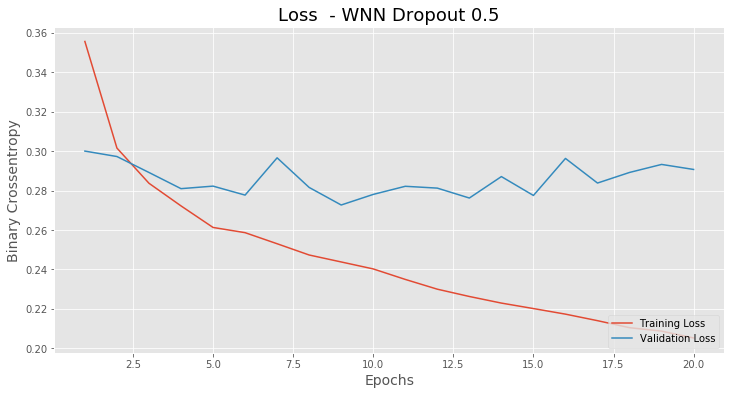

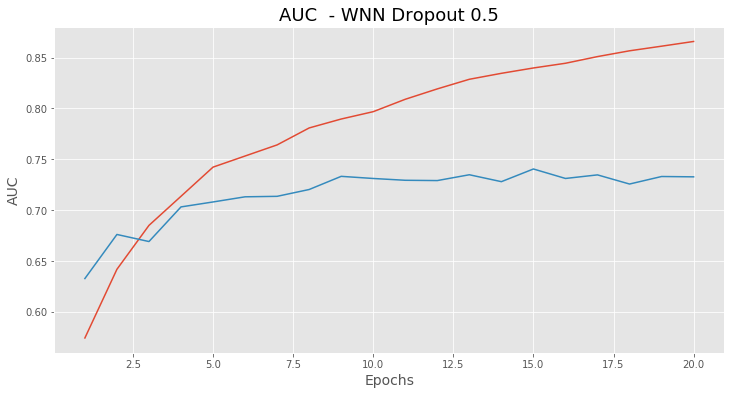

In [342]:
plot_history(dropout_0_5_history, model_name='WNN Dropout 0.5', 
             loss_name='Binary Crossentropy')

## Visualizing Dropout's Effect

Plotting loss and AUC of all dropout models on a single graph to see if the relationship between dropout rate and AUC/loss becomes clearer.

### Making a List of All History Objects

In [0]:
history_list = [dropout_0_1_history, dropout_model_0_25_history, dropout_0_5_history]

### Extracting Losses

In [0]:
# Empty lists first
lost_lists = []
val_loss_lists = []
auc_lists = []
val_auc_lists = []

# Extracting list of training losses # 
loss_lists = [history.history['loss'] for history in history_list]
val_loss_lists = [history.history['val_loss'] for history in history_list]

# Epochs will be the same as the length of any given loss list
epochs = range(1, len(loss_lists[0]) + 1)

### Extracting all AUCs

In [0]:
def get_auc(histories):
  auc_list = []
  for history in histories:
    for key in history.history.keys():
      if 'auc' in key and 'val' not in key:
         auc_list.append(history.history[key])
  
  return auc_list

def get_val_auc(histories):
  val_auc_list = []
  for history in histories:
    for key in history.history.keys():
      if 'auc' in key and 'val' in key:
        val_auc_list.append(history.history[key])
        
  return val_auc_list

In [0]:
# Extracting list of accuracies will be more difficult
auc_lists = get_auc(history_list)
val_auc_lists = get_val_auc(history_list)

### Plotting Losses and AUCs

In [347]:
len(loss_lists)

3

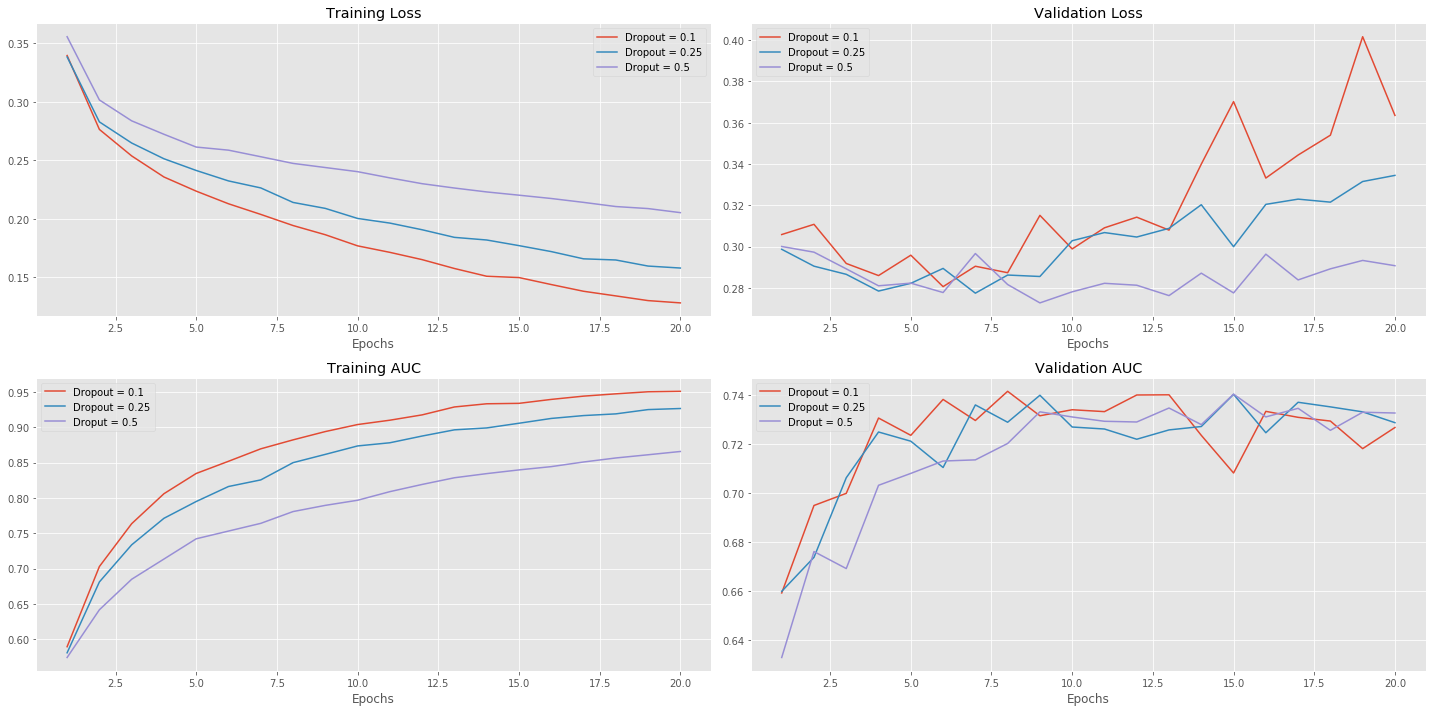

In [348]:
# Labels for each plot in same order as dropout rates of models
labels = ['Dropout = 0.1', 'Dropout = 0.25', 'Droput = 0.5']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 10))

for i in range(0, len(loss_lists)):
  ax1.plot(epochs, loss_lists[i])
  ax2.plot(epochs, val_loss_lists[i])
  ax3.plot(epochs, auc_lists[i])
  ax4.plot(epochs, val_auc_lists[i])

for ax in (ax1, ax2, ax3, ax4):
  ax.set_xlabel('Epochs')
  ax.legend(labels) 

ax1.set_title('Training Loss'); ax2.set_title('Validation Loss')
ax3.set_title('Training AUC'); ax4.set_title('Validation AUC')

plt.tight_layout()

## Summary of Results - Dropout
- Addition of a `Dropout` layer does not seem to improve validation set AUC, which still plateaus at ~0.74.
- The training AUC continues to increase, but that is likely due to overfitting.
- Validation loss seems to increase after 8 epochs, suggesting overfitting.
- Increasing the dropout rate from 0.1 to 0.5 seems to make the convergence more stable, but decreases the overall AUC/increases overall loss.
- Noisy validation results indicate that the validation set is too small.

# WNN with `MinMax` Scaling

So far I've used `StandardScaler` because it was giving better performance than `MinMax` scaling on the `LogisticRegression` shallow learing model I built earlier.

I'm going to try investigating the performance of the WNN with `MinMaxScaler` data.

## Scaling Data

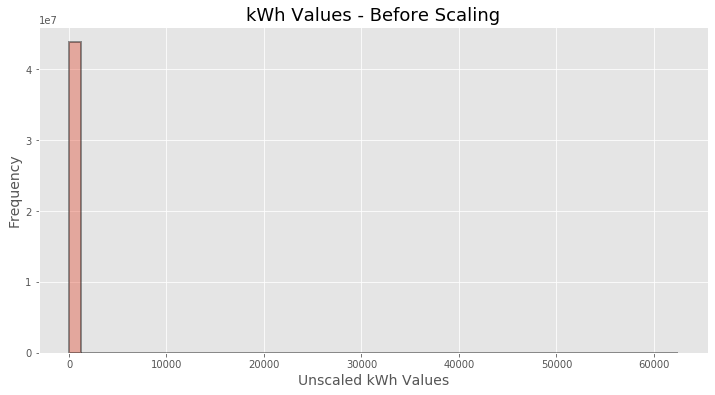

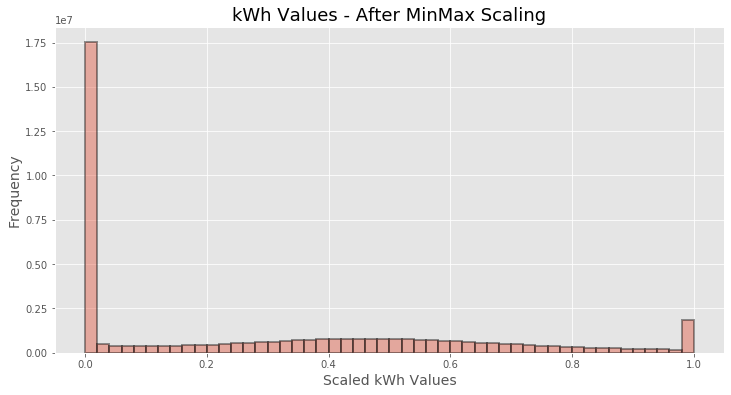

In [371]:
X_scaled_minmax = scale_features(X=kWhs, plot_distributions=True, 
                                 scaling_strategy='MinMax')

In [372]:
X_scaled_minmax.shape

(42372, 1034)

## Train-Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_minmax, 
                                                    labels, 
                                                    stratify=labels, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True)

In [382]:
y_train.shape

(33897,)

In [383]:
y_test.shape

(8475,)

## Building Model

In [0]:
wnn_minmax = Sequential()
wnn_minmax.add(Dense(units=90, input_shape=(1034, ), activation='relu'))
wnn_minmax.add(Dense(units=1, activation='sigmoid'))

In [0]:
wnn_minmax.compile(optimizer='rmsprop', 
                   loss='binary_crossentropy',
                   metrics=[AUC()])

## Training

In [386]:
wnn_minmax_history = wnn_minmax.fit(X_train, y_train, 
                               validation_split=0.2, 
                               epochs=20, 
                               batch_size=128, 
                               verbose=1)

Train on 27117 samples, validate on 6780 samples
Epoch 1/20
27117/27117 [==============================] - 2s 59us/sample - loss: 0.3196 - auc_29: 0.5791 - val_loss: 0.2910 - val_auc_29: 0.6631
Epoch 2/20
27117/27117 [==============================] - 1s 39us/sample - loss: 0.2757 - auc_29: 0.6707 - val_loss: 0.2777 - val_auc_29: 0.6723
Epoch 3/20
27117/27117 [==============================] - 1s 37us/sample - loss: 0.2653 - auc_29: 0.7135 - val_loss: 0.2720 - val_auc_29: 0.7226
Epoch 4/20
27117/27117 [==============================] - 1s 38us/sample - loss: 0.2598 - auc_29: 0.7354 - val_loss: 0.2659 - val_auc_29: 0.7299
Epoch 5/20
27117/27117 [==============================] - 1s 39us/sample - loss: 0.2553 - auc_29: 0.7508 - val_loss: 0.2697 - val_auc_29: 0.7271
Epoch 6/20
27117/27117 [==============================] - 1s 43us/sample - loss: 0.2515 - auc_29: 0.7618 - val_loss: 0.2720 - val_auc_29: 0.7394
Epoch 7/20
27117/27117 [==============================] - 1s 38us/sample - loss: 

## Training History

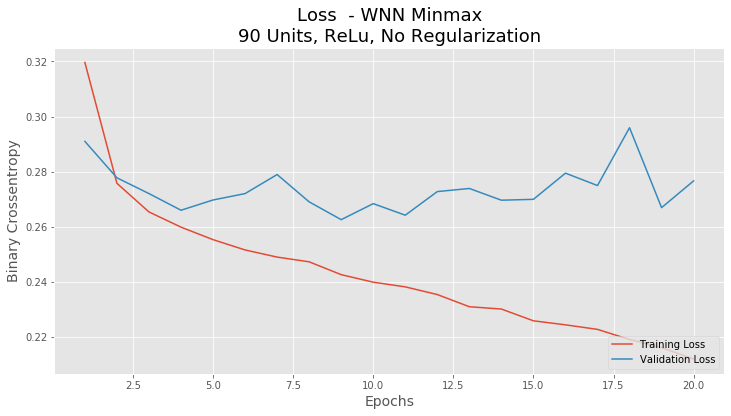

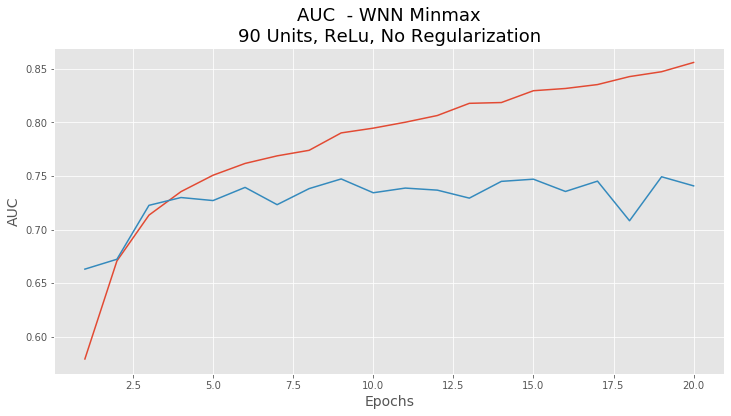

In [387]:
plot_history(history=wnn_minmax_history, 
             model_name='WNN Minmax\n90 Units, ReLu, No Regularization')

## Effect of Dropout

### Instantiating Models

All models have
- an `Dropout` layer with the specified `dropout_rate` value.
- an `Dense` input layer of 90 neurons, `ReLu` activation, with `input_shape` of (1034, ).
- a `Dense` output layer with a single `sigmoid` unit.

These models are compiled with an `rmsprop` optimizer, `loss` of `binary_crossentropy`, and `metric` of `AUC()`.

In [0]:
wnn_dropout_0_1 = build_dropout_model(0.1)
wnn_dropout_0_25 = build_dropout_model(0.25)
wnn_dropout_0_5 = build_dropout_model(0.5)

### Training Models

In [0]:
wnn_dropout_0_1_history = wnn_dropout_0_1.fit(X_train, y_train, 
                                    batch_size=128, 
                                    epochs=20, 
                                    validation_split=0.2, 
                                    verbose=0)

In [0]:
wnn_dropout_0_25_history = wnn_dropout_0_25.fit(X_train, y_train,
                                                batch_size=128, 
                                                epochs=20, 
                                                validation_split=0.2,
                                                verbose=0)

In [0]:
wnn_dropout_0_5_history = wnn_dropout_0_5.fit(X_train, y_train, 
                                              batch_size=128, 
                                              epochs=20, 
                                              validation_split=0.2, 
                                              verbose=0)

### Visualizing Losses and AUCs

In [0]:
# Extracting list of history values
history_list = [wnn_dropout_0_1_history, 
                wnn_dropout_0_25_history, 
                wnn_dropout_0_5_history]

In [0]:
# Empty lists first
lost_lists = []
val_loss_lists = []
auc_lists = []
val_auc_lists = []

In [0]:
# Extracting list of training losses # 
loss_lists = [history.history['loss'] for history in history_list]
val_loss_lists = [history.history['val_loss'] for history in history_list]

# Epochs will be the same as the length of any given loss list
epochs = range(1, len(loss_lists[0]) + 1)

In [0]:
# Extracting list of accuracies will be more difficult - uses functions defined earlier
auc_lists = get_auc(history_list)
val_auc_lists = get_val_auc(history_list)

Text(0.5, 0.98, 'Effect of Dropout on WNN\nTrained on MinMax Scaled Data')

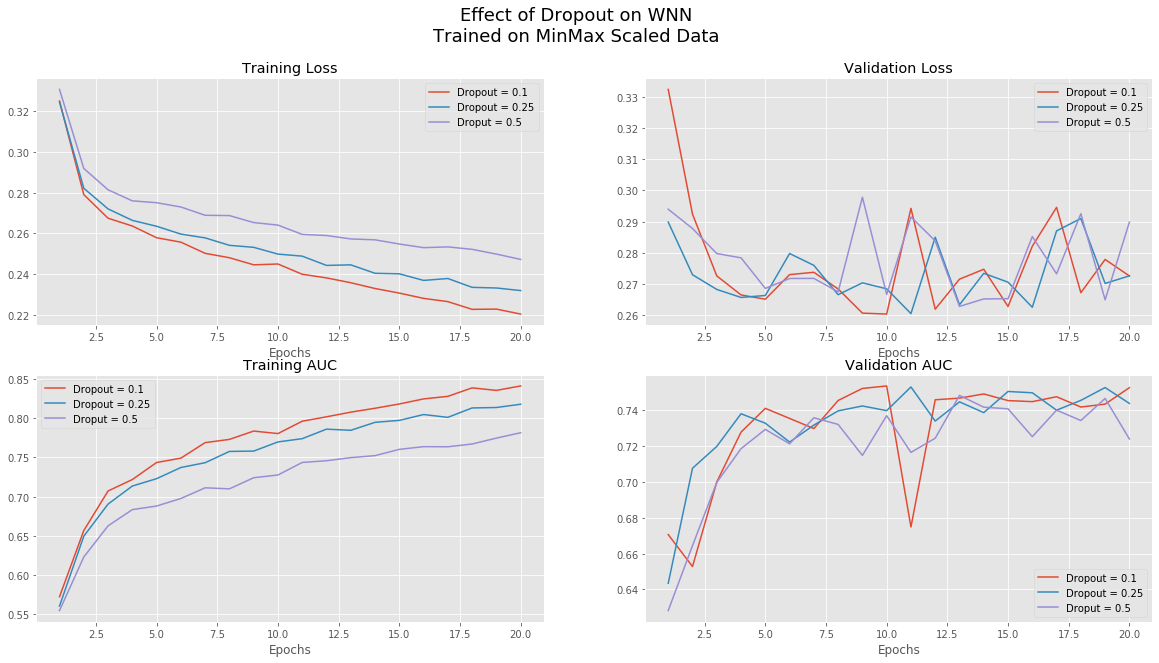

In [404]:
# Labels for each plot in same order as dropout rates of models
labels = ['Dropout = 0.1', 'Dropout = 0.25', 'Droput = 0.5']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 10))

for i in range(0, len(loss_lists)):
  ax1.plot(epochs, loss_lists[i])
  ax2.plot(epochs, val_loss_lists[i])
  ax3.plot(epochs, auc_lists[i])
  ax4.plot(epochs, val_auc_lists[i])

for ax in (ax1, ax2, ax3, ax4):
  ax.set_xlabel('Epochs')
  ax.legend(labels) 

ax1.set_title('Training Loss'); ax2.set_title('Validation Loss')
ax3.set_title('Training AUC'); ax4.set_title('Validation AUC')
fig.suptitle('Effect of Dropout on WNN\nTrained on MinMax Scaled Data', fontsize=18)